In [26]:
# Importing necessary modules
import os
import sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras.metrics import Precision, Recall
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import sys
import matplotlib.pyplot as plt

In [3]:
# Importing functions from functions.py. This gets them from GitHub.

!wget -O functions.py https://raw.githubusercontent.com/up941791/ACT_2/main/py/functions.py
import functions as fn

--2026-01-05 09:48:56--  https://raw.githubusercontent.com/up941791/ACT_2/main/py/functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143 [text/plain]
Saving to: ‘functions.py’

functions.py        100%[===================>]     143  --.-KB/s    in 0s      

2026-01-05 09:48:56 (3.25 MB/s) - ‘functions.py’ saved [143/143]



In [4]:
# Downloading the dataset

os.environ['KAGGLE_USERNAME'] = 'samhedley'
os.environ['KAGGLE_KEY'] = 'KGAT_b7cd8b87cb2a0346ef10f-b182f099721'
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria --unzip

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 98% 663M/675M [00:01<00:00, 276MB/s] 
100% 675M/675M [00:01<00:00, 371MB/s]


In [5]:
data_dir = "./cell_images" # Directory for the dataset

In [6]:
# Function to split dataset paths into training, validation, and test set paths
def split_dataset_paths(folder_path, test_size, val_size):

    split_paths = {'train': [], 'val': [], 'test': []}

    for label in ['Parasitized', 'Uninfected']: # Looping through both classes
        imgs = [] # List to hold valid image paths
        class_dir = os.path.join(folder_path, label) # Directory for the current class
        for img_name in os.listdir(class_dir): # Looping through images in the class directory
            img_path = os.path.join(class_dir, img_name) # Full path to the image
            
            imgs.append((img_path, label)) # Append image path and label

        train_imgs, temp_imgs = train_test_split(imgs, test_size=test_size + val_size, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_size / (test_size + val_size), random_state=42)

        split_paths['train'].extend(train_imgs)
        split_paths['val'].extend(val_imgs)
        split_paths['test'].extend(test_imgs)

    return split_paths

In [7]:
# Splitting dataset into train, val, and test sets
split_paths = split_dataset_paths(data_dir, test_size=0.15, val_size=0.15) 

In [8]:
# Checking the number of samples in each split
print("Training samples:", len(split_paths['train']))
print("Validation samples:", len(split_paths['val']))
print("Test samples:", len(split_paths['test']))

Training samples: 19292
Validation samples: 4134
Test samples: 4134


In [9]:
# Creating dataframes for each split
train_df = fn.make_dataframe(split_paths, 'train')
val_df = fn.make_dataframe(split_paths, 'val')
test_df = fn.make_dataframe(split_paths, 'test')

In [10]:
# Setting up ImageDataGenerators for training, validation, and test sets

target_size = (128, 128) # Target size for image resizing
batch_size = 64 # Batch size for training and validation

datagen = ImageDataGenerator(rescale=1./255) # Scaling pixel values to [0, 1]

train_gen = datagen.flow_from_dataframe( # Training data generator
    train_df,
    x_col='img_path',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = datagen.flow_from_dataframe( # Validation data generator
    val_df,
    x_col='img_path',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = datagen.flow_from_dataframe( # Test data generator
    test_df,
    x_col='img_path',
    y_col='label',
    target_size=target_size,
    batch_size=1,
    class_mode='binary'
)

Found 19290 validated image filenames belonging to 2 classes.
Found 4134 validated image filenames belonging to 2 classes.
Found 4134 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [41]:
# Setting up model checkpoints to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [42]:
# Setting up learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

In [43]:
# Setting up early stopping to stop if the model stops improving
earlystopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1,
    restore_best_weights=False
)

In [45]:
# List of callbacks to be used during training
callbacks_list = [checkpoint, reduce_lr, earlystopping]

In [46]:
# Building the CNN model

cNN = Sequential()

cNN.add(Input(shape=(128, 128, 3)))
cNN.add(Conv2D(32, (3, 3), activation='relu'))
cNN.add(MaxPooling2D((2, 2)))
cNN.add(Conv2D(64, (3, 3), activation='relu'))
cNN.add(MaxPooling2D((2, 2)))
cNN.add(Conv2D(128, (3, 3), activation='relu'))
cNN.add(MaxPooling2D((2, 2)))

cNN.add(Flatten())
cNN.add(Dense(64, activation='relu'))
cNN.add(Dropout(0.5))

cNN.add(Dense(1, activation='sigmoid'))

In [47]:
optimiser = Adam(learning_rate=0.001) # Setting the optimiser

cNN.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()]) # Compiling the model

In [48]:
# Training the model
train = cNN.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_list
)

Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6899 - loss: 0.5723 - precision_3: 0.6783 - recall_3: 0.7360
Epoch 1: val_accuracy improved from -inf to 0.94074, saving model to best_model.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 34s 101ms/step - accuracy: 0.6903 - loss: 0.5717 - precision_3: 0.6787 - recall_3: 0.7363 - val_accuracy: 0.9407 - val_loss: 0.2413 - val_precision_3: 0.9440 - val_recall_3: 0.9371 - learning_rate: 0.0010
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9343 - loss: 0.2110 - precision_3: 0.9369 - recall_3: 0.9314
Epoch 2: val_accuracy did not improve from 0.94074
302/302 ━━━━━━━━━━━━━━━━━━━━ 28s 94ms/step - accuracy: 0.9343 - loss: 0.2109 - precision_3: 0.9369 - recall_3: 0.9314 - val_accuracy: 0.9185 - val_loss: 0.3010 - val_precision_3: 0.9386 - val_recall_3: 0.8955 - learning_rate: 0.0010
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9449 - loss: 0.1655 - precision_3: 0.9357 - recall_3: 0.9550
Epoch 3: val

In [49]:
# Testing the model on the test set

cNN.load_weights('best_model.keras') # Loading the best model weights

test_loss, test_acc, precision, recall = cNN.evaluate(test_gen) # Evaluating on the test set

# Printing test results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

4134/4134 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9609 - loss: 0.1511 - precision_3: 0.9599 - recall_3: 0.9605
Test Accuracy: 0.9620
Test loss: 0.1582
Test Recall: 0.9637
Test Precision: 0.9605


In [51]:
cNN.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,097,029 (19.44 MB)

 Trainable params: 1,699,009 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,398,020 (12.96 MB)

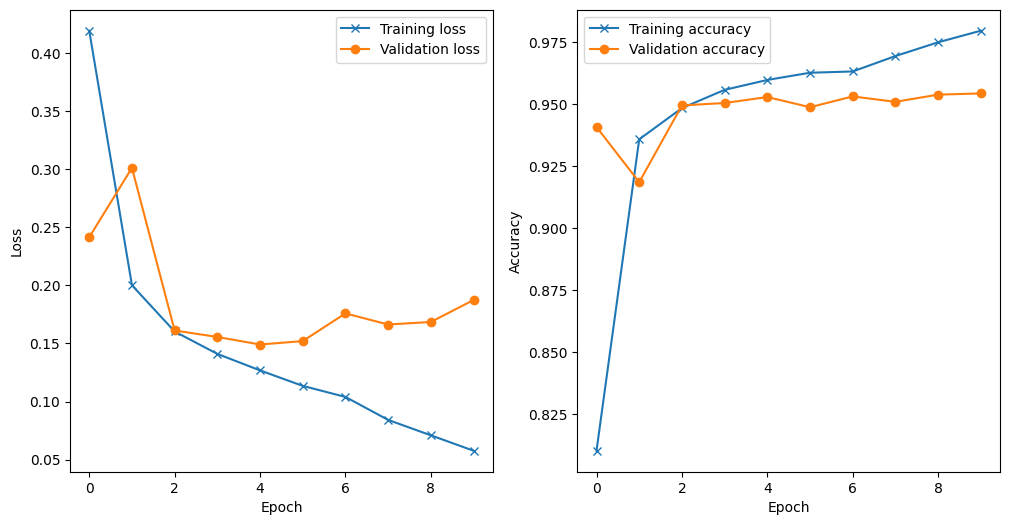

In [52]:
# Plotting loss
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(train.history['loss'], 'x-', label="Training loss")
plt.plot(train.history['val_loss'], 'o-', label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train.history['accuracy'], 'x-', label="Training accuracy")
plt.plot(train.history['val_accuracy'], 'o-', label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

2 Conv layers (removed 128 filter layer and corresponding maxpooling)

In [53]:
# Setting up model checkpoints to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model_2.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# List of callbacks to be used during training
callbacks_list_2 = [checkpoint, reduce_lr, earlystopping]

# Building the CNN model

cNN2 = Sequential()

cNN2.add(Input(shape=(128, 128, 3)))
cNN2.add(Conv2D(32, (3, 3), activation='relu'))
cNN2.add(MaxPooling2D((2, 2)))
cNN2.add(Conv2D(64, (3, 3), activation='relu'))
cNN2.add(MaxPooling2D((2, 2)))

cNN2.add(Flatten())
cNN2.add(Dense(64, activation='relu'))
cNN2.add(Dropout(0.5))

cNN2.add(Dense(1, activation='sigmoid'))


optimiser = Adam(learning_rate=0.001) # Setting the optimiser
cNN2.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()]) # Compiling the model

In [54]:
# Training the model
train = cNN2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_list_2
)

Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5751 - loss: 0.7424 - precision_4: 0.5774 - recall_4: 0.5995
Epoch 1: val_accuracy improved from -inf to 0.86647, saving model to best_model_2.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 34s 102ms/step - accuracy: 0.5753 - loss: 0.7421 - precision_4: 0.5776 - recall_4: 0.5996 - val_accuracy: 0.8665 - val_loss: 0.4722 - val_precision_4: 0.8752 - val_recall_4: 0.8549 - learning_rate: 0.0010
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8465 - loss: 0.4160 - precision_4: 0.8564 - recall_4: 0.8364
Epoch 2: val_accuracy improved from 0.86647 to 0.91050, saving model to best_model_2.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.8465 - loss: 0.4158 - precision_4: 0.8565 - recall_4: 0.8364 - val_accuracy: 0.9105 - val_loss: 0.2822 - val_precision_4: 0.8653 - val_recall_4: 0.9724 - learning_rate: 0.0010
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9036 - loss: 0.2675 - precision

In [55]:
# Testing the model on the test set

cNN2.load_weights('best_model_2.keras') # Loading the best model weights

test_loss, test_acc, precision, recall = cNN2.evaluate(test_gen) # Evaluating on the test set

# Printing test results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

4134/4134 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9456 - loss: 0.1823 - precision_4: 0.9375 - recall_4: 0.9563
Test Accuracy: 0.9405
Test loss: 0.2013
Test Recall: 0.9511
Test Precision: 0.9313


In [59]:
cNN2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,117,765 (42.41 MB)

 Trainable params: 3,705,921 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,411,844 (28.27 MB)

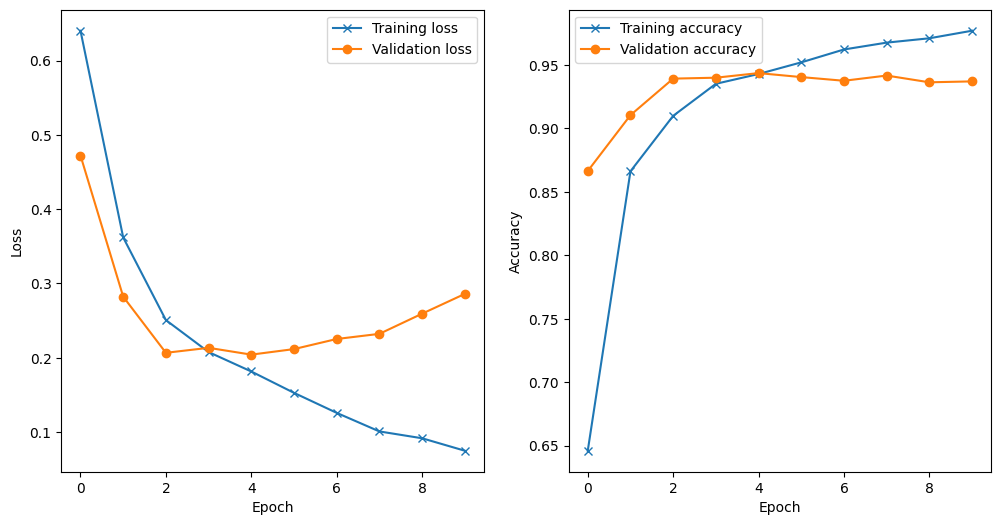

In [60]:
# Plotting loss
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(train.history['loss'], 'x-', label="Training loss")
plt.plot(train.history['val_loss'], 'o-', label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train.history['accuracy'], 'x-', label="Training accuracy")
plt.plot(train.history['val_accuracy'], 'o-', label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()